# Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) are a class of generative models that combine principles from variational inference and autoencoders. They are designed to model complex data distributions and have been widely used in tasks such as image generation, data compression, and anomaly detection.

In [1]:
%%capture
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

# Desactivar los warnings para evitar mensajes innecesarios durante la ejecución
import warnings

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

from likelihood.models.deep import (
    AutoClassifier,
    setup_model,
    GetInsights,
)  # Modelos de deep learning personalizados
from likelihood.tools import OneHotEncoder, get_metrics  # Herramientas auxiliares

warnings.filterwarnings("ignore")
import tensorflow as tf

import matplotlib.pyplot as plt

is_updated = False
from packaging import version

if version.parse(tf.__version__) > version.parse("2.15.0"):
    is_updated = True

plt.rcParams["font.size"] = 10
plt.style.use("seaborn-v0_8")

E0000 00:00:1755460643.013953  392339 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755460643.018473  392339 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755460643.030710  392339 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755460643.030730  392339 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755460643.030732  392339 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755460643.030734  392339 computation_placer.cc:177] computation placer already registered. Please check linka

## Table of Contents

1. [Introduction](#introduction)
2. [Autoencoders Overview](#autoencoders-overview)
3. [Variational Inference](#variational-inference)
4. [Variational Autoencoder Architecture](#variational-autoencoder-architecture)
5. [Training VAEs](#training-vaes)
6. [Applications of VAEs](#applications-of-vaes)

## 1. Introduction

Variational Autoencoders (VAEs) are generative models that learn to represent high-dimensional data in a lower-dimensional latent space. They are particularly effective in capturing the underlying structure of data, making them valuable for tasks such as:

- Image generation
- Data compression
- Anomaly detection

## 2. Autoencoders Overview

An autoencoder is a neural network architecture designed to learn efficient representations of data. It consists of two main components:

- **Encoder**: Compresses the input data into a latent space representation.
- **Decoder**: Reconstructs the input data from the latent representation.

The goal is to minimize the reconstruction error, ensuring that the decoder can accurately reconstruct the input from the compressed representation.

## 3. Variational Inference

Variational inference is a technique used to approximate complex probability distributions. In the context of VAEs, it involves:

- **Latent Variables**: Variables that capture the underlying factors of variation in the data.
- **Variational Distribution**: An approximation to the true posterior distribution of the latent variables given the data.

The objective is to find the variational distribution that is closest to the true posterior, typically by minimizing the Kullback-Leibler (KL) divergence between them.

## 4. Variational Autoencoder Architecture

The VAE architecture extends the traditional autoencoder by introducing probabilistic elements:

- **Encoder**: Outputs parameters (mean and variance) of the variational distribution.
- **Latent Space**: Samples from the variational distribution to obtain latent variables.
- **Decoder**: Reconstructs the data from the latent variables.

The VAE is trained to maximize the Evidence Lower Bound (ELBO), which balances:

- **Reconstruction Loss**: Measures how well the decoder reconstructs the input data.
- **KL Divergence**: Measures how closely the variational distribution approximates the prior distribution.

## 5. Training VAEs

Training a VAE involves:

1. **Sampling**: From the variational distribution to obtain latent variables.
2. **Reconstruction**: Using the decoder to reconstruct the input data.
3. **Loss Calculation**: Computing the ELBO, which includes reconstruction loss and KL divergence.
4. **Optimization**: Updating the model parameters to maximize the ELBO.

This process encourages the model to learn a latent space that captures the underlying structure of the data.

## 6. Applications of VAEs

VAEs have been applied in various domains, including:

- **Image Generation**: Creating new images that resemble the training data.
- **Data Compression**: Reducing the dimensionality of data while preserving essential information.
- **Anomaly Detection**: Identifying data points that deviate significantly from the learned distribution.


Variational Autoencoders are powerful generative models that combine the strengths of autoencoders and variational inference. They are capable of learning complex data distributions and have a wide range of applications in machine learning and data analysis.

For further reading and advanced topics, consider exploring the following resources:

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)


In [2]:
# Cargar el dataset de cáncer de mama desde sklearn
df = datasets.load_breast_cancer()

# Convertir los datos a un DataFrame de pandas para facilitar la manipulación
df_cancer = pd.DataFrame(data=df.data, columns=df.feature_names)
df_cancer["target"] = df.target  # Añadir la columna de etiquetas 'target'

# OneHotEncoder convierte las etiquetas a formato one-hot encoding
y_encoder = OneHotEncoder()
y = y_encoder.encode(df_cancer["target"].to_list())  # Codificar las etiquetas de la clase (target)
X = df_cancer.drop(
    columns="target"
).to_numpy()  # Extraer las características (sin la columna 'target')
X = np.asarray(X).astype(np.float32)  # Convertir X a tipo float32 para la entrada del modelo
y = np.asarray(y).astype(np.float32)  # Convertir y a tipo float32

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Crear el modelo de clasificación automática con las especificaciones dadas
model = AutoClassifier(
    input_shape_parm=X.shape[1],  # El número de características de entrada (columnas de X)
    num_classes=y.shape[1],  # El número de clases (salidas) del modelo
    units=17,  # Número de unidades en las capas ocultas
    activation="relu",  # Función de activación de las capas ocultas
    l2_reg=0.0,
    vae_mode=True,
)

# Compilación del modelo: optimizador, función de pérdida y métricas
model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Pre-entrenamiento del encoder-decoder para el uso de un VAE
model.train_encoder_decoder(X, epochs=1_000, batch_size=32, verbose=False)

# Entrenar el modelo con los datos, usando 15 épocas y 20% de los datos para validación
if is_updated:
    model.compile(
        optimizer="adam",  # Optimizador Adam
        loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
        metrics=[
            tf.keras.metrics.F1Score(threshold=0.5)
        ],  # Métrica F1 (threshold = 0.5 para predicciones)
    )
model.fit(X_train, y_train, epochs=15, validation_split=0.2, verbose=False)

# Hacer predicciones sobre el conjunto de entrenamiento
pred = model.predict(X)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df = df_cancer.copy()
y_labels = df.drop(columns="target").columns.to_list()
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1

# Calcular y mostrar las métricas del modelo comparando las etiquetas reales y las predicciones
get_metrics(df_cancer, "target", "prediction", verbose=True)

# Guardar el DataFrame con las predicciones en un archivo CSV
df_cancer.to_csv("test.csv", index=False)

# Guardar el modelo entrenado en el disco en formato TensorFlow
if is_updated:
    model.save("best_model")
else:
    model.save("best_model", save_format="tf")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 71.70%
Precision: 86.03%
Recall: 65.55%
F1-Score: 74.40
Cohen's Kappa: 0.4404


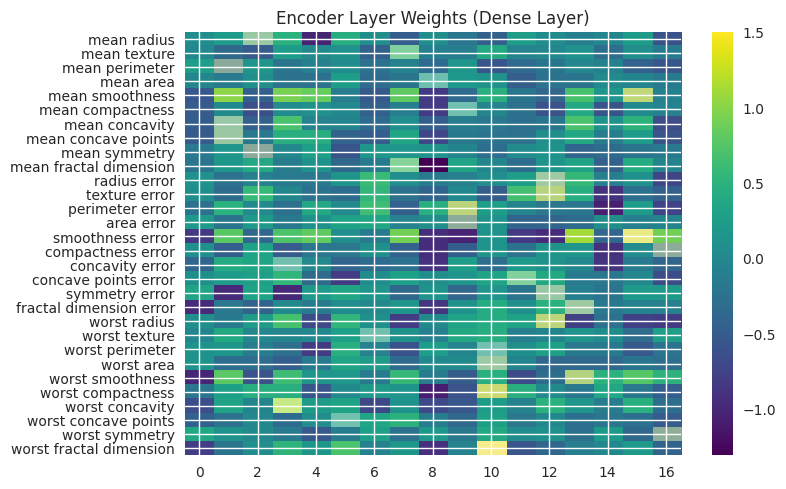

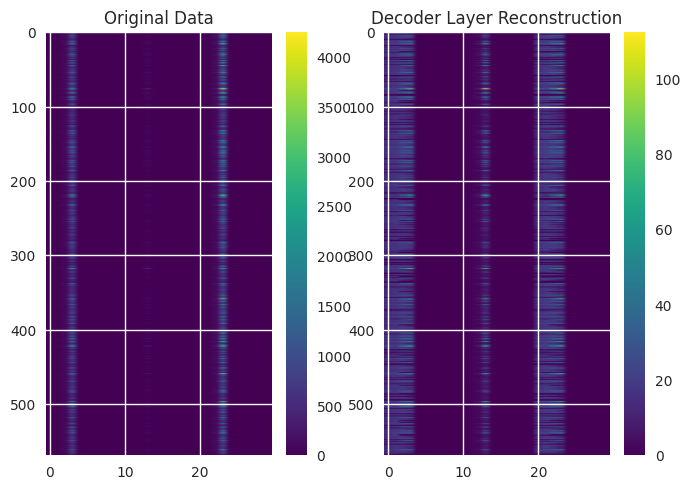

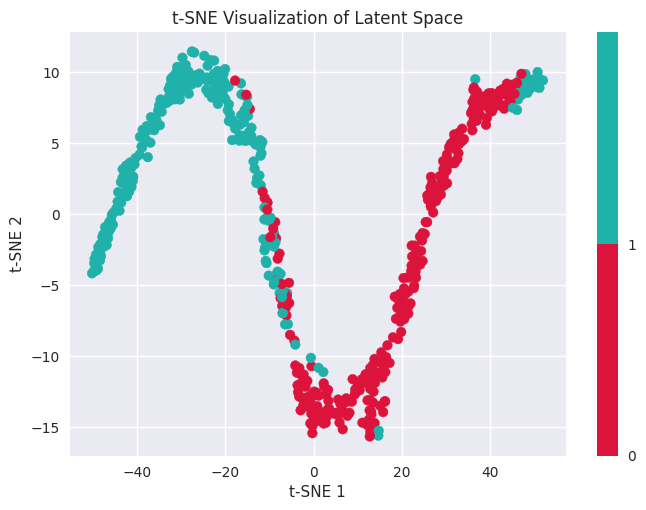

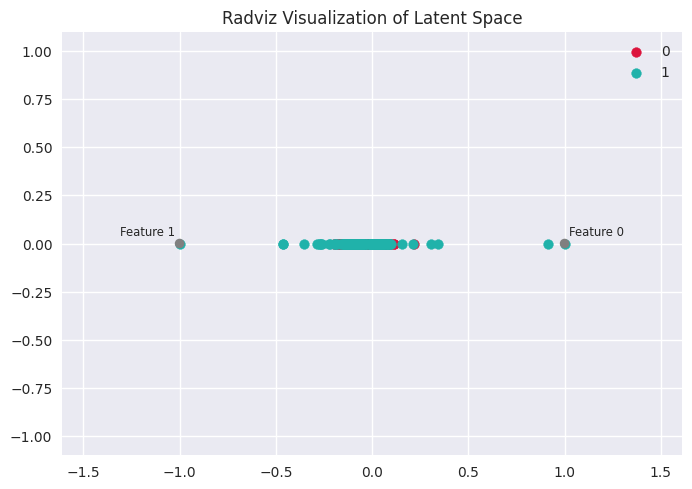

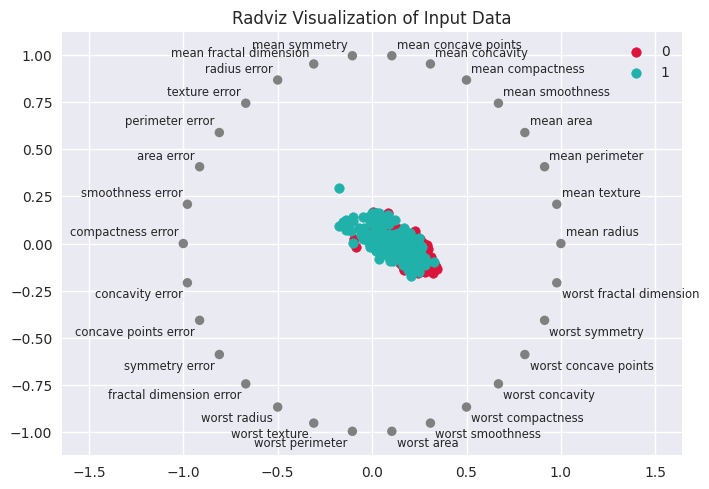

In [4]:
insights = GetInsights(model, X)
summary = insights.predictor_analyzer(frac=1.0, y_labels=y_labels)

In [5]:
# Cargar el modelo guardado desde el disco
if is_updated:
    model = AutoClassifier.load("best_model")
else:
    model = tf.keras.models.load_model("best_model")
print("Modelo cargado desde disco.")
# Fine-tuning del modelo con más épocas de entrenamiento
model.freeze_encoder_decoder()  # Congelar las capas de encoder y decoder
model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)
model.fit(X_train, y_train, epochs=15, validation_split=0.2, verbose=False)
model.summary()

if is_updated:
    model.save("fine_tuned_model")
else:
    model.save("fine_tuned_model", save_format="tf")
print("Modelo fine-tuned guardado en disco.")
if is_updated:
    model = AutoClassifier.load("fine_tuned_model")
else:
    model = tf.keras.models.load_model("fine_tuned_model")
print("Modelo fine-tuned cargado desde disco.")

# Hacer predicciones nuevamente con el modelo fine-tuned
pred = model.predict(X)

# Obtener las etiquetas predichas para las nuevas predicciones
pred_label = np.argmax(pred, axis=1)

# Añadir las nuevas predicciones al DataFrame original
df["prediction"] = pred_label

# Calcular y mostrar las métricas nuevamente con el modelo fine-tuned
get_metrics(df, "target", "prediction", verbose=True)

Modelo cargado desde disco.
=== AutoClassifier Summary ===

--- Encoder ---


Model: "vae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_encoder_dense_1 │ (None, 17)        │        527 │ encoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_encoder_bn_1    │ (None, 17)        │         68 │ vae_encoder_dens… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_encoder_act_1   │ (None, 17)        │          0 │ vae_encoder_bn_1… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_hidden      │ (None, 8)         │        144 │ vae_encoder_act_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_encoder_bn_2    │ (None, 8)         │         32 │ encoder_hidden[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_encoder_act_2   │ (None, 8)         │          0 │ vae_encoder_bn_2… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 2)         │         18 │ vae_encoder_act_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         18 │ vae_encoder_act_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var_stabilized  │ (None, 2)         │          0 │ log_var[0][0]     │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 807 (3.15 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 807 (3.15 KB)


--- Decoder ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_decoder_dense_1 (Dense)     │ (None, 17)             │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_decoder_bn_1                │ (None, 17)             │            68 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_decoder_act_1 (Activation)  │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_decoder_dense_2 (Dense)     │ (None, 30)             │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_decoder_bn_2                │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vae_decoder_act_2 (Activation)  │ (None, 30)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 779 (3.04 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 779 (3.04 KB)


--- Classifier ---


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ classifier_input (InputLayer)   │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66 (264.00 B)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 0 (0.00 B)


--- Main Model ---


Model: "auto_classifier_main"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_encoder         │ [(None, 2),       │        807 │ main_input[0][0]  │
│ (Functional)        │ (None, 2)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_layer      │ (None, 2)         │          0 │ vae_encoder[0][0… │
│ (Lambda)            │                   │            │ vae_encoder[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 30)        │        779 │ sampling_layer[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_features    │ (None, 32)        │          0 │ decoder[0][0],    │
│ (Concatenate)       │                   │            │ sampling_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier          │ (None, 2)         │         66 │ combine_features… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,786 (6.98 KB)

 Trainable params: 66 (264.00 B)

 Non-trainable params: 1,586 (6.20 KB)

 Optimizer params: 134 (540.00 B)

Modelo fine-tuned guardado en disco.
Modelo fine-tuned cargado desde disco.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 86.99%
Precision: 90.08%
Recall: 89.08%
F1-Score: 89.58
Cohen's Kappa: 0.7229


In [6]:
if is_updated:
    model = AutoClassifier.load("best_model")
else:
    model = tf.keras.models.load_model("best_model")

pred = model.predict(X)
# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1
get_metrics(df_cancer, "target", "prediction", verbose=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 69.77%
Precision: 84.39%
Recall: 63.59%
F1-Score: 72.52
Cohen's Kappa: 0.4037


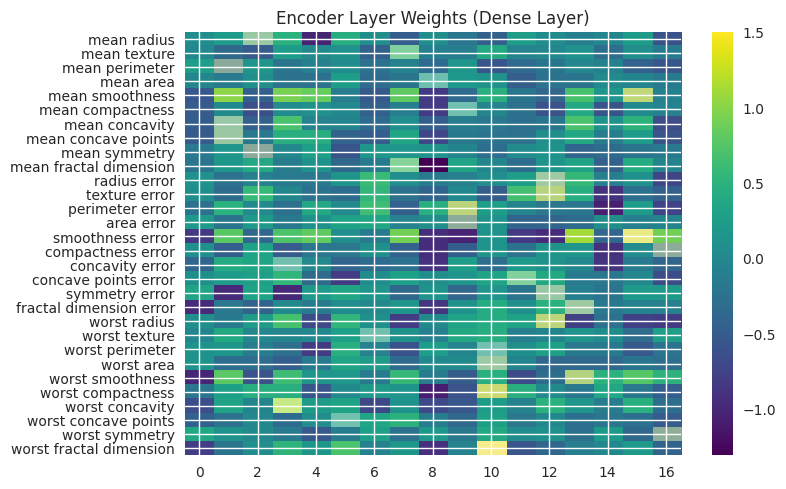

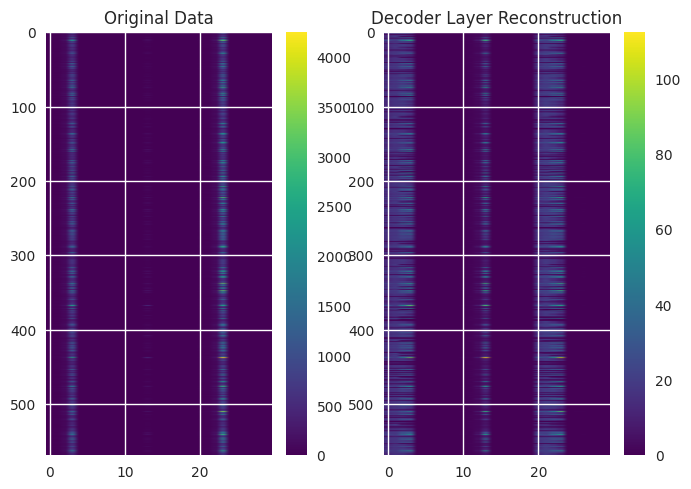

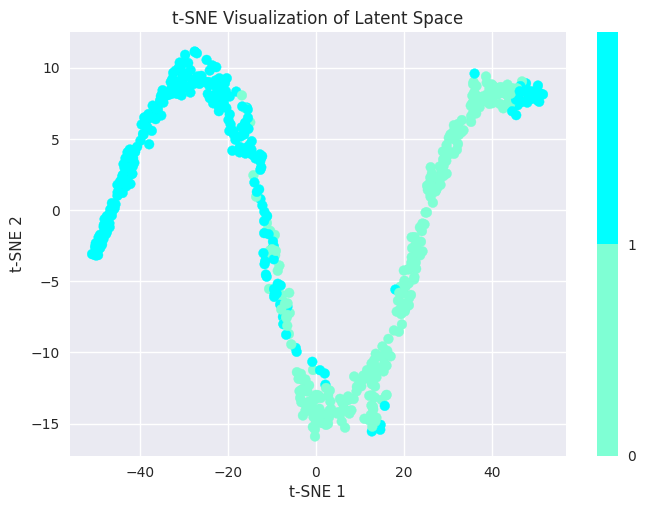

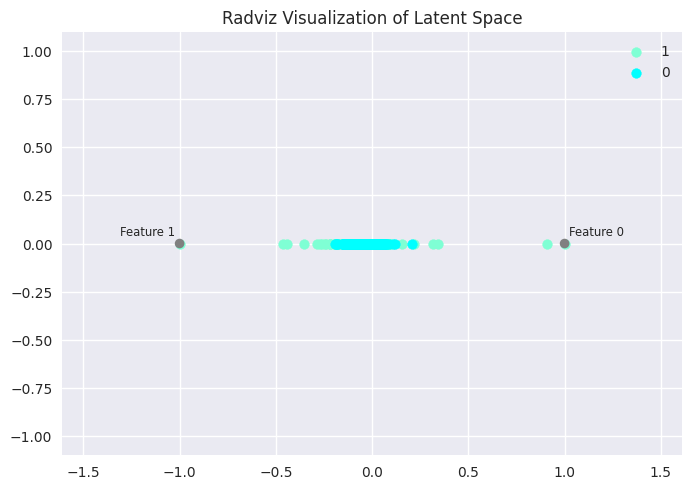

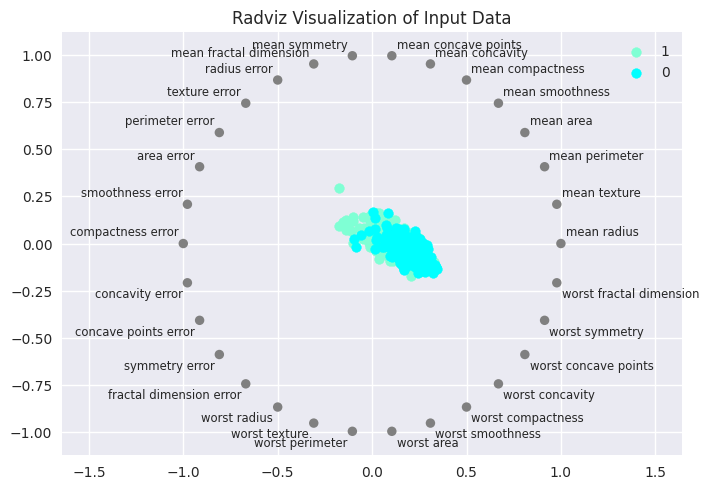

In [7]:
insights = GetInsights(model, X)
summary = insights.predictor_analyzer(frac=1.0, y_labels=y_labels)